# Чтение данных

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
df = pd.read_csv('spam_dataset/train_spam.csv')
print(df.shape)
df.head()

(16278, 2)


,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [ ]:
target_map = {'ham': 0, 'spam': 1}
reversed_target_map = dict((v, k) for k, v in target_map.items())

df['target'] = df['text_type'].map(target_map)  

# Посмотрим на данные

Посмотрим на дубликаты, чтобы они не попали в трейн и тест. И удалим их.

In [ ]:
print('Количество дубликатов: ', df.duplicated().sum())

df = df.drop_duplicates()

Количество дубликатов:  11


Посмотрим на сторки, имеющие одинаковый текст, но разный таргет.

In [ ]:
repeated = df.groupby('text').filter(lambda x: x['target'].nunique() > 1)
print(f"Количество противоречащих строк: {len(repeated)}")

Количество противоречащих строк: 0


Удалим мусор из текста, чтобы посмотреть на наиболее частотные слова в спаме и не спаме, а также использовать подготовленный текст для обучения tf-idf.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /home/gregyar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gregyar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/gregyar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gregyar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [ ]:
df['prep_text'] = df.apply(lambda row: preprocess(row.text), axis=1)

Посмотрим на данные, чтобы по статистике построить простенький классификатор. При этом будем смотреть только на трейн чтобы не было лика.

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

<Axes: >

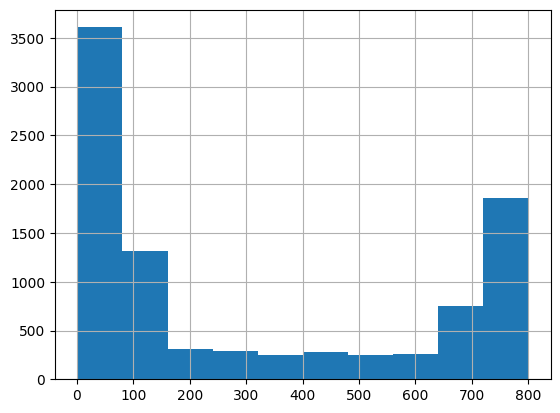

In [ ]:
train_data.loc[train_data['text_type'] == 'ham']['text'].str.len().hist()

<Axes: >

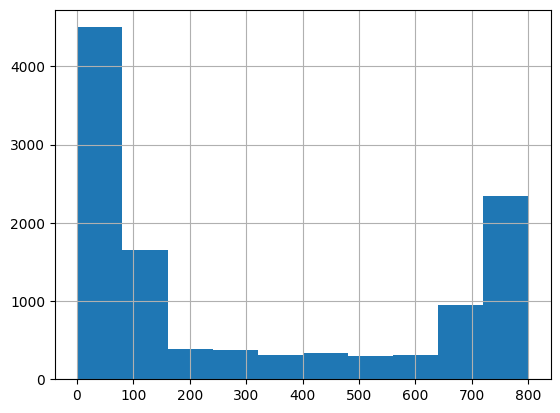

In [ ]:
df.loc[df['text_type'] == 'ham']['text'].str.len().hist()

Посчитаем ниболее частотные слова в спаме и не спаме.

In [ ]:
from collections import Counter

most_common_words_spam = [tup[0] for tup in Counter(" ".join(train_data.loc[train_data['text_type'] == 'spam']["prep_text"]).split()).most_common(100)]


print(most_common_words_spam[:10])

most_common_words_ham = [tup[0] for tup in Counter(" ".join(train_data.loc[train_data['text_type'] == 'ham']["prep_text"]).split()).most_common(100)]


print(most_common_words_ham[:10])

most_common_words_spam = set(most_common_words_spam)
most_common_words_ham = set(most_common_words_ham)

['free', 'get', 'u', 'call', 'new', 'r', 'click', 'link', 'one', 'com']
['ect', 'enron', 'vince', 'url', 'hou', 'kaminski', 'u', 'subject', 'j', 'please']


На основе полученной статистики соберём простенький классификатор

In [ ]:
def predict_by_common_words(text):
    ham_intersection = {key: value for key, value in Counter(text.split()).items() if key in most_common_words_ham}
    spam_intersection = {key: value for key, value in Counter(text.split()).items() if key in most_common_words_spam}

    if sum(ham_intersection.values()) == sum(spam_intersection.values()):
        if len(text) <= 100:
            return 0
        else:
            return 1
    elif sum(ham_intersection.values()) >= sum(spam_intersection.values()):
        return 0
    else:
        return 1

In [ ]:
pred = val_data['prep_text'].apply(predict_by_common_words)

print(
    f'val accuracy: {accuracy_score(val_data["target"], pred)}\n'
    f'val roc auc: {roc_auc_score(val_data["target"], pred)}'
)

val accuracy: 0.8414259373079287
val roc auc: 0.8349560797204776


# Baseline

В качестве бэйзлайна обучим логрег на td-idf.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf_idf = TfidfVectorizer().fit(train_data['prep_text'])
train_tf_idf = tf_idf.transform(train_data['prep_text'])
val_tf_idf = tf_idf.transform(val_data['prep_text'])

In [ ]:
log_regr = LogisticRegression(n_jobs=-1).fit(train_tf_idf, train_data['target'])

train_pred = log_regr.predict(train_tf_idf)
test_pred = log_regr.predict(val_tf_idf)

print(
    f'Train acc: {accuracy_score(train_data["target"],train_pred):.4f} '
    f'Train roc: {roc_auc_score(train_data["target"],train_pred):.4f}\n'
    f'Test acc: {accuracy_score(val_data["target"], test_pred):.4f} '
    f'Test roc: {roc_auc_score(val_data["target"],test_pred):.4f}'
)


Train acc: 0.9498 Train roc: 0.9255
Test acc: 0.9256 Test roc: 0.8932


# Encoder fine tune

В качестве модели для файнтюна выберим модель, которая обучалась на твиттере, где будет похожий формат сообщений, и также решалась задача аналогичная нашей.

In [29]:
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import BertTokenizerFast, AutoConfig, AutoTokenizer

model_name = 'Delphia/twitter-spam-classifier'

configuration = AutoConfig.from_pretrained(model_name)
configuration.hidden_dropout_prob = 0.2
configuration.attention_probs_dropout_prob = 0.2

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  ignore_mismatched_sizes=True,
  config=configuration
)

In [88]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, test_mode=False, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.mem = {}
        self.max_length = max_length
        self.test_mode = test_mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if index not in self.mem:
            text = self.data.iloc[index]['text']
            tokenized_inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
            input_ids = tokenized_inputs.input_ids.squeeze(0)
            attention_mask = tokenized_inputs.attention_mask.squeeze(0)
            
            self.mem[index] = {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                }
            
        if self.test_mode:
            return {
            'tokenized_inputs': self.mem[index],
        }
            
        labels = self.data.iloc[index]['target']
        labels = torch.tensor(labels, dtype=torch.long)

        return {
            'tokenized_inputs': self.mem[index],
            'labels': labels
        }

In [71]:
train_dataset = TextDataset(train_data, tokenizer)
val_dataset = TextDataset(val_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [30]:
train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []
train_aucroc_values = []
val_aucroc_values = []

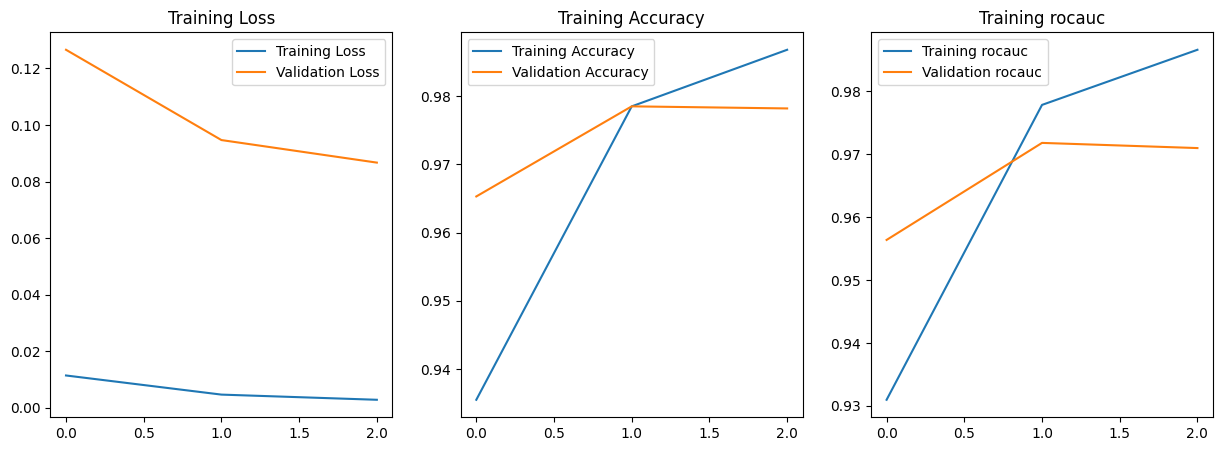

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup


num_epochs = 3
total_steps = len(train_loader) * num_epochs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
normedWeights = df['target'].value_counts(normalize=True).sort_index().values
normedWeights = torch.Tensor([1 - x for x in normedWeights]).to(device)
softmax = nn.Softmax(dim=-1)

model.to(device)
criterion = nn.CrossEntropyLoss(normedWeights)
optimizer = optim.AdamW(model.parameters(),  
                        lr = 2e-5,
                        weight_decay=0.01
                    )

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

for epoch in range(num_epochs):

    model.train()
    
    true_train = []
    pred_train = []
    true_val = []
    pred_val = []
    pred_probs_train = []
    pred_probs_val = []
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        inputs, labels = data['tokenized_inputs'], data['labels'].to(device)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.logits.cpu(), 1)

        true_train.extend(labels.cpu())
        pred_train.extend(predicted)
        pred_probs_train.extend(softmax(outputs.logits)[:, 1])
        running_loss += loss.item()

    if scheduler is not None:
        scheduler.step() 

    epoch_loss_train = running_loss / len(train_dataset)

    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for data in tqdm(val_loader):
            inputs, labels = data['tokenized_inputs'], data['labels'].to(device)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)

            _, predicted = torch.max(outputs.logits.cpu(), 1)

            true_val.extend(labels.cpu())
            pred_val.extend(predicted)
            pred_probs_val.extend(softmax(outputs.logits)[:, 1])
            running_loss += loss.item()
            
    torch.save(model, f'{epoch}-model.pt')
            

    epoch_loss_val = running_loss / len(val_loader)

    train_loss_values.append(epoch_loss_train)
    train_accuracy_values.append(accuracy_score(true_train, pred_train))
    train_aucroc_values.append(roc_auc_score(true_train, pred_train))
    val_loss_values.append(epoch_loss_val)
    val_accuracy_values.append(accuracy_score(true_val, pred_val))
    val_aucroc_values.append(roc_auc_score(true_val, pred_val))

    
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_loss_train:.4f}, '
          f'Train Accuracy: {train_accuracy_values[-1]:.4f}, '
          f'Train rocauc: {train_aucroc_values[-1]:.4f}, '
          f'Val Loss: {epoch_loss_val:.4f}, '
          f'Val Accuracy: {val_accuracy_values[-1]:.4f}'
          f'val rocauc: {val_aucroc_values[-1]:.4f}, '
         )
    
    clear_output(wait=True)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(train_loss_values, label='Training Loss')
    axs[0].plot(val_loss_values, label='Validation Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()

    axs[1].plot(train_accuracy_values, label='Training Accuracy')
    axs[1].plot(val_accuracy_values, label='Validation Accuracy')

    axs[1].set_title('Training Accuracy')
    axs[1].legend()
    
    axs[2].plot(train_aucroc_values, label='Training rocauc')
    axs[2].plot(val_aucroc_values, label='Validation rocauc')
    axs[2].set_title('Training rocauc')
    axs[2].legend()

    plt.show()

# Посчитаем предсказания на тесте с помощью лучшей модели

В качестве лучше модели выберем - последнюю, так как она показала лучшие результаты. Но при этом в зависимости от бизнес требований и наличия железа можно использовать модель обученную на tf-idf.

In [34]:
test_data = pd.read_csv('spam_dataset/test_spam.csv')
test_dataset = TextDataset(test_data, tokenizer, test_mode=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [36]:
best_model = torch.load('1-model.pt')
best_model.to(device)
best_model.eval();

In [37]:
scores = []

with torch.no_grad():
    for data in tqdm(test_loader):
        inputs = data['tokenized_inputs']
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = best_model(**inputs)

        scores.extend(softmax(outputs.logits)[:, 1].cpu().numpy())

100%|██████████| 128/128 [01:17<00:00,  1.65it/s]


In [40]:
result = pd.DataFrame({
    'score': scores,
    'text': test_data.text
})

result.to_csv("test_scores.csv", index=False)